# Part 1: Integer Programming

Operations research often involves models where you need to make discrete decisions. 

Suppose Iain wants to carry items to the pawn shop to get some extra cash. He has $N$ items, each with a weight $w_i$ and a price $p_i$. Iain hasn't been to the gym lately, so he can only carry $C$ kilos. How does he choose what to bring with him?

We can model this as an integer optimization problem:

\begin{align*}
\max& \sum_{i=1}^N p_i x_i \\
\text{s.t.}& \sum_{i=1}^N w_i x_i \leq C \\
& x_i \in \{0,1\} \quad \forall i = 1,\ldots,N
\end{align*}


## Example

In particular, consider the following (small) knapsack problem:

\begin{align*}
    \max\:& x + y \\
    \text{s.t.}\:& x + 2y \leq 1.5 \\
    & x, y \in \{0,1\}
\end{align*}

How would you solve this? 

In [5]:
using JuMP, Gurobi
knapsackModel=Model(solver=GurobiSolver(Presolve=0))
@variable(knapsackModel, x, Bin)
@variable(knapsackModel, y, Bin)
@constraint(knapsackModel, x+2*y<=1.5)
@objective(knapsackModel, Max, x+y)
solve(knapsackModel)
println("X is: ", getvalue(x), " Y is: ", getvalue(y))

Academic license - for non-commercial use only
Optimize a model with 1 rows, 2 columns and 2 nonzeros
Variable types: 0 continuous, 2 integer (2 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 1.0000000
Variable types: 0 continuous, 2 integer (2 binary)

Root relaxation: cutoff, 0 iterations, 0.00 seconds

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 1: 1 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.000000000000e+00, best bound 1.000000000000e+00, gap 0.0000%
X is: 1.0 Y is: -0.0


┌ Warning: Deprecated syntax `implicit assignment to global variable `#29###377``.
│ Use `global #29###377` instead.
└ @ nothing none:0
┌ Warning: Deprecated syntax `implicit assignment to global variable `#31###378``.
│ Use `global #31###378` instead.
└ @ nothing none:0


## Branch and Bound Tree

The simple way is just to consider each possible value for $x$ and $y$ and compare the cost.

![alt text](img/tree_1.png)

In the general case, this would lead to $2^N$ possible collections of items. After Iain has weighed all of them (and verified that he can lift them at once), he just chooses the best set.


Let's visualize this approach as a search tree:

![alt text](img/tree_2.png)

It's rooted at what we call the _relaxation_: none of variables have integrality enforced. As we go down leaves of the tree, we add pick a variable to _branch_ on, and create two descended nodes that fix that variable to one of its possible values. If we follow the tree all the way to the bottom, we reach our enumeration from before.

As we go down the arcs of the tree we restrict our problem more and more, we must have that:

>If node ``q`` is descended from node ``p``, we must have that the optimal cost of subproblem ``q`` is no more than that for node ``p``

This leads us to a powerful tool in solving these enumeration problems: 

>If I can show you that the optimal cost for subproblem ``q`` is _less_ than the optimal cost for the original problem, the same is true for any descendent of ``q``. 


That is, we can _prune_ the tree and safely discard some nodes, kind of like this:

![alt text](img/tree_3.png)

## Worked Example

\begin{align*}
    \max\quad& x + y \\
    \text{s.t.}\quad& x + 2y \leq 1.5 \\
    & 0 \leq x, y \leq 1 \\
    & x, y \in \{0,1\}
\end{align*}

What does the relaxation (no integrality restrictions) of this problem look like?

* First, we solve the LP relaxation and get $(x^*,y^*) = (1,0.25)$. 
* This isn't integer feasible, so we branch on $y$. The subproblem with $y = 1$ is infeasible, and the subproblem with $y = 0$ is feasible with solution $(x^*,y^*) = (1,0)$. This is integer feasible, so we update our lower bound. We've also exhausted the tree, so we have our optimal solution!
* The branch-and-bound scheme can end up solving many subproblems, so for it to work well, we need to _prune_ large portions of the tree. 

## Branch and bound
We'll keep track of a global _lower bound_ $LB$ for our problem. Each node ``q`` will have an upper bound $UB_q$ that it inherents from its parent. If we get to the point where we have solved all subproblems (or, ideally, pruned off a great deal of them), we know that we're optimal. To do this we'll also keep track of a list $L$ of subproblems left to solve; initially, it's just the relaxation. The procedure is:

While $L$ is not empty, pick a subproblem ``q`` out of our list $L$ and solve it. 
1. ``if`` ``q`` is infeasible, ``continue``
2. ``if`` the solution is integer feasible, update the lower bound $LB$ if the cost is higher than what we had before
3. ``if``  the relaxation value is less than our global $LB$ ``continue``
4. ``else`` pick a non-integer variable $i$ and _branch_ by adding two subproblems to $L$: 
    * One with $x_i = 0$
    * Another with $x_i = 1$

Branch-and-bound is sometimes called an _implicit enumeration_ scheme because of step 3: we avoid solving any subproblems that we can prove won't produce the optimal solution.

**The "magic" of modern MIP solvers largely comes down to pruning massive portions of the tree. Some of this is essentially beyond your control, but there are four things which you can do.**


## Stuff you should care about
**We care about four distinct attributes:**

1) **Correctness** (Are "feasible" solutions feasible? Are "optimal" solutions optimal?)

2) **Time taken** (fast is every user's favourite feature).

3) **Bound quality** (how good is the lower bound?).

4) **Solution quality** (how good is the best solution identified?)

In the first part of this session, we will focus on attributes 3-4, through the lens of the travelling salesperson problem (TSP), while taking attribute 1 for granted (improving 3-4 improves 2). In part 3 of this session, we will circle back to this idea, and look at attribute 1 more closely. 

**In general, you should try to solve a problem in a quick-and-dirty way, and see which attribute needs working on.**

**E.g, if you find the optimal solution straight away but need lots of time to prove optimality then focus on bound quality.**

# Improving bound quality

One way to improve the bound quality is by adding cuts to a relaxation, such as the LP relaxation.

Cuts are inequalities that are _valid_ (don't cut off any feasible integer points) and _strengthen_ the formulation (chop off some of the region feasible for the relaxation)

Three main types of cuts:

1. General purpose (e.g. CG, split, MIR)
2. Structure-specific (e.g. knapsack cover, clique)
3. Problem-specific (whatever _you_ cook up)

Generally speaking, solvers can add general purpose and structure specific cuts better than we can. However, we are better at adding problem specific cuts. Therefore, when trying to improve bound quality, a good place to start is identifying problem structure which a solver hasn't found, and exploiting this problem structure.

## Improving solution quality

One way to improve the incumbent solution quality is to obtain integer feasible solutions apriori. These can come from:

1. Problem-specific heuristics.
2. Neighborhood search.
3. Rounding or "polishing" existing high-quality solutions.

For instance, if we're solving a knapsack problem, one simple heuristic is to add a _greedy solution_ where you iteratively add the best available item to the sack until you run out of room. This will often be a very good solution, and is a simple example of a problem-specific heuristic scheme.

# A TSP example from the JuliaOpt/JuMP.jl examples repository



We begin by loading the required modules. Note that you can run this code using either CPLEX or Gurobi.

In [13]:
using JuMP
using CPLEX #Gurobi
using Test
using LinearAlgebra
using DelimitedFiles
using Gadfly

Next, we define a function to extract a n+1 dimensional vector representing a tour from an n x n symmetric matrix representing a solution provided by a solver.

In [10]:
function extractTour(n, sol)
    tour = [1]  # Start at city 1 always
    cur_city = 1
    while true
        # Look for first arc out of current city
        for j = 1:n
            if sol[cur_city,j] >= 0.5-1e-6
                # Found next city
                push!(tour, j)
                # Don't ever use this arc again
                sol[cur_city, j] = 0.0
                sol[j, cur_city] = 0.0
                # Move to next city
                cur_city = j
                break
            end
        end
        # If we have come back to 1, stop
        if cur_city == 1
            break
        end
    end  # end while
    return tour
end

extractTour (generic function with 1 method)

Next, we define a function which acts as a seperation oracle, and either identifies a subtour which should be banned from the set of all possible solutions, or decides that the current solution is optimal.

In [11]:
# Input:
#  n        Number of cities
#  sol      n-by-n 0-1 symmetric matrix representing solution
# Outputs:
#  subtour  n length vector of booleans, true iff in a particular subtour
#  subtour_length   Number of cities in subtour (if n, no subtour found)
function findSubtour(n, sol)
    # Initialize to no subtour
    subtour = fill(false,n)
    #=
    # Always start looking at city 1
    cur_city = 1
    =#
    # Start looking at a random city: much faster because we explore different subtours
    cur_city=rand(1:n)
    subtour[cur_city] = true
    subtour_length = 1
    while true
        # Find next node that we haven't yet visited
        found_city = false
        indices=shuffle(1:n)
        for j = 1:n
            if !subtour[indices[j]]
                if sol[cur_city, indices[j]] >= 1 - 1e-6
                    # Arc to unvisited city, follow it
                    cur_city = indices[j]
                    subtour[indices[j]] = true
                    found_city = true
                    subtour_length += 1
                    break  # Move on to next city
                end
            end
        end
        if !found_city
            # We are done
            break
        end
    end
    return subtour, subtour_length
end

findSubtour (generic function with 1 method)

Next, we define a function which solves TSP, given a matrix of city locations, using an optimization solver.

In [12]:
# Inputs:
#   n       Number of cities
#   cities  n-by-2 matrix of (x,y) city locations
# Output:
#   path    Vector with order to cities are visited in
function solveTSP(n, cities)

    # Calculate pairwise distance matrix
    dist = zeros(n, n)
    for i = 1:n
        for j = i:n
            d = norm(cities[i,1:2] - cities[j,1:2])
            dist[i,j] = d
            dist[j,i] = d
        end
    end

    m = Model(solver=CplexSolver(CPX_PARAM_TILIM=100))
    #m=Model(solver=GurobiSolver())

    # x[i,j] is 1 iff we travel between i and j, 0 otherwise. 
    # Although we define all n^2 variables, we will only use the (strict) upper triangle. 
    @variable(m, x[1:n,1:n], Bin)

    # Minimize total length of tour
    @objective(m, Min, dot(dist, x))

    # Make x_ij and x_ji be the same thing (undirectional TSP)
    @constraint(m, x.==x')
    # Don't allow self-arcs, by ensuring diagonal is vector of 0s
    @constraint(m, diag(x).==zeros(n))

    # We must enter and leave every city once and only once
    for i = 1:n
        @constraint(m, sum(x[i,j] for j=1:n) == 2)
    end

    function subtour(cb)
        # Find any set of cities in a subtour
        @time subtour, subtour_length = findSubtour(n, getvalue(x))

        if subtour_length == n
            # This "subtour" is actually all cities, so we are done with this node of the branch and bound tree
            return
        end

        # Subtour found - add lazy constraint
        arcs_from_subtour = zero(AffExpr)
        for i = 1:n
            if subtour[i]
            # If this city isn't in subtour, skip it
                for j = 1:n
                    # Want to include all arcs from this city, which is in the subtour, 
                    # to all cities not in the subtour
                    if (i !=j) && !(subtour[j])
                        # j isn't in subtour
                        arcs_from_subtour += x[i,j]
                    end
                end
            end
        end
        # Add the subtour elimination constraint
        @lazyconstraint(cb, arcs_from_subtour >= 2)
    end 

    addlazycallback(m, subtour)
    solve(m)

    return extractTour(n, getvalue(x))
end

solveTSP (generic function with 1 method)

Next, we define a function to plot the solution

In [14]:
plot_instance(pts) = plot(x = pts[1,:], y = pts[2,:], Geom.point, Guide.xlabel(nothing), Guide.ylabel(nothing))
function plot_solution(pts, path, extras = [])
	ptspath = pts[:,path]
	plot(x = ptspath[1,:], y = ptspath[2,:], Geom.point, Geom.path, Guide.xlabel(nothing), Guide.ylabel(nothing), extras...)
end

plot_solution (generic function with 2 methods)

Next, we solve a small 6 by 6 example to verify correctness of our code.

CPXPARAM_TimeLimit                               100
CPXPARAM_Preprocessing_Reduce                    1
CPXPARAM_Preprocessing_Linear                    0
CPXPARAM_MIP_Strategy_CallbackReducedLP          0
Tried aggregator 2 times.
MIP Presolve eliminated 27 rows and 6 columns.
Aggregator did 15 substitutions.
Reduced MIP has 6 rows, 15 columns, and 30 nonzeros.
Reduced MIP has 15 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.00 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.01 ticks)
  0.000015 seconds (6 allocations: 912 bytes)
  0.000010 seconds (9 allocations: 1.266 KiB)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0     0      integral     0     2494.4272     1694.4272        

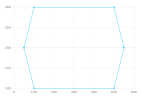

In [17]:
n = 6
cities =    [50 200;
            100 100;
            100 300;
            500 100;
            500 300;
            550 200]
tour = solveTSP(n, cities)

plot_solution(cities', tour)

# A more complicated TSP example
What's the quickest tour around the 48 US state capitals in the mainland US?

In [21]:
# Source: https://people.sc.fsu.edu/~jburkardt/datasets/tsp/att48.tsp
n=48
citiesdata=[6734 1453;
2233 10;
5530 1424;
401 841;
3082 1644;
7608 4458;
7573 3716;
7265 1268;
6898 1885;
1112 2049;
5468 2606;
5989 2873;
4706 2674;
4612 2035;
6347 2683;
6107 669;
7611 5184;
7462 3590;
7732 4723;
5900 3561;
4483 3369;
6101 1110;
5199 2182;
1633 2809;
4307 2322;
675 1006;
7555 4819;
7541 3981;
3177 756;
7352 4506;
7545 2801;
3245 3305;
6426 3173;
4608 1198;
23 2216;
7248 3779;
7762 4595;
7392 2244;
3484 2829;
6271 2135;
4985 140;
1916 1569;
7280 4899;
7509 3239;
10 2676;
6807 2993;
5185 3258;
3023 1942]
tour = solveTSP(n, citiesdata);

CPXPARAM_TimeLimit                               100
CPXPARAM_Preprocessing_Reduce                    1
CPXPARAM_Preprocessing_Linear                    0
CPXPARAM_MIP_Strategy_CallbackReducedLP          0
Tried aggregator 2 times.
MIP Presolve eliminated 1224 rows and 48 columns.
Aggregator did 1128 substitutions.
Reduced MIP has 48 rows, 1128 columns, and 2256 nonzeros.
Reduced MIP has 1128 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.64 ticks)
Probing time = 0.00 sec. (0.18 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.96 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

      0     0    63338.5149    14                  63338.5149       82         
  0.000051 seconds (11 allocations: 21.969 KiB)
  0.000064 seconds (1

Plot the optimal tour

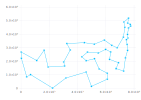

In [19]:
plot_solution(citiesdata', tour)

* Run this with branching on
* Run this with only cuts on
* Discuss the difference

# A larger-scale TSP: Routing a Vehicle

In [22]:

ludata=readdlm("bcl380tsp.txt")
ludata=ludata[:, 2:3] #drop index

n=380
tour = solveTSP(n, ludata[1:n, :])

# Comment on how starting from a random city is much better
# Maybe start off with from city 1 and then move on to random starting city?
# Imparts a nice lesson that little tricks like that are usually the difference between sucess and failure when coding in research


CPXPARAM_TimeLimit                               100
CPXPARAM_Preprocessing_Reduce                    1
CPXPARAM_Preprocessing_Linear                    0
CPXPARAM_MIP_Strategy_CallbackReducedLP          0
Tried aggregator 2 times.
MIP Presolve eliminated 72770 rows and 380 columns.
Aggregator did 72010 substitutions.
Reduced MIP has 380 rows, 72010 columns, and 144020 nonzeros.
Reduced MIP has 72010 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.25 sec. (179.87 ticks)
Probing time = 0.05 sec. (11.19 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.10 sec. (49.69 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

      0     0     3117.8756    46                   3117.8756      516         
      0     0     3132.5069    22                    Cuts

Add `using DelimitedFiles` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
Add `using LinearAlgebra` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
Add `using LinearAlgebra` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
Add `using LinearAlgebra` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
Add `using LinearAlgebra` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
Add `using LinearAlgebra` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
in solveTSP at In[12]


  0.002161 seconds (28 allocations: 1.176 MiB)
  0.003920 seconds (275 allocations: 1.929 MiB)
  0.003777 seconds (370 allocations: 2.219 MiB)
  0.002237 seconds (88 allocations: 1.359 MiB)
  0.001922 seconds (9 allocations: 1.118 MiB)
  0.003553 seconds (223 allocations: 1.771 MiB)
      0     2     3141.7841    32                   3142.0516      636         
Elapsed time = 29.57 sec. (6705.04 ticks, tree = 0.01 MB, solutions = 0)
      5     7     3143.0566    23                   3142.8390      653         
     11    13     3143.5051     8                   3142.8390      664         
     18    20     3143.9530    14                   3142.8390      678         
  0.001934 seconds (8 allocations: 1.115 MiB)
     24    26     3155.6926    19                   3142.8390      706         
  0.003281 seconds (15 allocations: 1.136 MiB)
     32    34     3159.5687    14                   3142.8390      731         
     40    42     3162.6636     6                   3142.8390      753

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/Ryancw2/.julia/packages/JuMP/Xvn0n/src/solvers.jl:212
┌ Warning: `Array{T, 1}(m::Int) where T` is deprecated, use `Array{T, 1}(undef, m)` instead.
│   caller = get_error_msg(::CPLEX.Env, ::Int32) at cpx_env.jl:67
└ @ CPLEX /Users/Ryancw2/.julia/packages/CPLEX/DkMdP/src/cpx_env.jl:67



Cover cuts applied:  10
Zero-half cuts applied:  44
Gomory fractional cuts applied:  13
User cuts applied:  25

Root node processing (before b&c):
  Real time             =   29.57 sec. (6704.59 ticks)
Sequential b&c:
  Real time             =   71.91 sec. (12258.87 ticks)
                          ------------
Total (root+branch&cut) =  101.49 sec. (18963.46 ticks)
CPLEX Error  1217: No solution exists.


┌ Warning: Variable value not defined for component of x. Check that the model was properly solved.
└ @ JuMP /Users/Ryancw2/.julia/packages/JuMP/Xvn0n/src/JuMP.jl:475


1-element Array{Int64,1}:
 1

That didn't work very well!

**What went wrong?**

a) TSP is NP-hard, so we can't solve it and we should just give up.

b) **We have been focusing on lower bounds, but we also need good heuristics to get good upper bounds.**

We will use the package TravelingSalesmanHeuristics.jl to generate a high-quality warm-start

In [9]:
#Pkg.clone("https://github.com/evanfields/TravelingSalesmanHeuristics.jl/")
using TravelingSalesmanHeuristics

In [23]:
# Calculate pairwise distance matrix for a heuristic
dist = [norm(ludata[i,:] - ludata[j,:]) for i in 1:n, j in 1:n]

Add `using LinearAlgebra` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
Add `using LinearAlgebra` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
Add `using LinearAlgebra` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
Add `using LinearAlgebra` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
Add `using LinearAlgebra` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
Add `using LinearAlgebra` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
Add `using LinearAlgebra` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
Add `using LinearAlgebra` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
in #6 at none


380×380 Array{Float64,2}:
   0.0       88.0      87.0      86.0     …  114.237   106.775   101.637 
  88.0        0.0       1.0       2.0        103.74    110.023   118.431 
  87.0        1.0       0.0       1.0        103.446   109.59    117.886 
  86.0        2.0       1.0       0.0        103.16    109.165   117.346 
  85.0        3.0       2.0       1.0        102.883   108.747   116.812 
  84.0        4.0       3.0       2.0     …  102.616   108.337   116.284 
  80.0        8.0       7.0       6.0        101.637   106.775   114.237 
  75.0       13.0      12.0      11.0        100.623   105.005   111.826 
  59.0       29.0      28.0      27.0         99.0202  100.807   105.342 
  48.0       40.0      39.0      38.0         99.4082   99.3227  102.108 
  37.0       51.0      50.0      49.0     …  101.0      99.0454   99.985 
  11.0       77.0      76.0      75.0        109.165   103.16     99.7246
   5.38516   83.0241   82.0244   81.0247     110.059   103.121    98.656 
   ⋮        

In [25]:
Random.seed!(47)
path, cost=solve_tsp(dist, quality_factor = 100)

  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41


([343, 344, 355, 345, 346, 356, 347, 334, 333, 332  …  379, 380, 374, 375, 354, 331, 340, 341, 342, 343], 1705.0746884947876)

The above solution is pretty good. But we obtain a better solution after injecting the above solution as a warm-start and letting a MIO solver run for 10 hours.

In [34]:
tour=[1, 14, 13, 12, 35, 34, 33, 32, 31, 52, 50, 49, 11, 30, 39, 29, 10, 28, 9, 27, 38, 26, 25, 8, 24, 37, 23, 7, 6, 5, 4, 3, 2, 22, 21, 36, 20, 16, 15, 51, 54, 70, 84, 72, 87, 81, 88, 93, 112, 111, 110, 109, 108, 107, 106, 105, 104, 101, 115, 146, 181, 160, 177, 168, 178, 169, 179, 191, 180, 170, 154, 155, 156, 157, 171, 172, 173, 182, 183, 192, 184, 185, 193, 186, 187, 188, 189, 174, 175, 190, 176, 152, 153, 158, 159, 161, 162, 163, 164, 165, 209, 208, 207, 206, 205, 204, 203, 202, 233, 201, 200, 240, 243, 251, 268, 252, 253, 269, 282, 318, 317, 316, 315, 281, 280, 314, 313, 312, 311, 310, 279, 278, 307, 306, 305, 304, 303, 309, 301, 300, 299, 298, 275, 276, 249, 250, 267, 199, 198, 197, 196, 236, 232, 231, 230, 229, 228, 266, 274, 297, 296, 295, 294, 293, 308, 292, 291, 324, 322, 328, 330, 327, 329, 326, 321, 320, 325, 290, 289, 288, 287, 259, 260, 261, 272, 262, 263, 273, 264, 265, 246, 227, 226, 225, 224, 223, 222, 221, 235, 220, 219, 218, 217, 216, 215, 214, 213, 212, 234, 211, 210, 195, 237, 238, 245, 242, 247, 248, 256, 270, 257, 258, 271, 284, 285, 286, 338, 357, 369, 336, 302, 323, 339, 352, 365, 376, 377, 378, 358, 348, 349, 350, 351, 359, 370, 360, 361, 371, 379, 380, 362, 363, 364, 372, 366, 367, 373, 374, 375, 353, 354, 331, 340, 341, 342, 343, 344, 355, 332, 333, 334, 345, 346, 347, 356, 335, 368, 337, 319, 277, 283, 255, 254, 244, 241, 239, 194, 167, 166, 150, 147, 148, 151, 149, 141, 140, 139, 138, 145, 137, 136, 135, 134, 133, 103, 102, 100, 99, 98, 97, 130, 96, 129, 128, 127, 126, 125, 124, 123, 122, 132, 121, 120, 119, 118, 144, 143, 142, 117, 116, 114, 131, 113, 89, 82, 94, 83, 95, 66, 67, 90, 91, 92, 68, 60, 85, 61, 69, 73, 74, 75, 76, 77, 59, 57, 62, 63, 64, 78, 79, 80, 86, 71, 65, 19, 48, 47, 46, 18, 17, 45, 44, 56, 58, 55, 43, 42, 53, 41, 40, 1]
path=tour;

Let's define a new version of solveTSP which takes a warm start solution, and tunes CPLEX more cleverly.

In [29]:
function solveTSP(n, cities)

    # Calculate pairwise distance matrix
    dist = [norm(ludata[i,:] - ludata[j,:]) for i in 1:n, j in 1:n]

    m = Model(solver=CplexSolver(CPX_PARAM_TILIM=3600, CPX_PARAM_COVERS =-1,CPX_PARAM_ZEROHALFCUTS=-1, CPX_PARAM_FRACCUTS=-1))
    #m=Model(solver=GurobiSolver())

    # x[i,j] is 1 iff we travel between i and j, 0 otherwise. 
    # Although we define all n^2 variables, we will only use the (strict) upper triangle. 
    @variable(m, x[1:n,1:n], Bin)

    # Minimize total length of tour
    @objective(m, Min, dot(dist, x))

    # Make x_ij and x_ji be the same thing (undirectional TSP)
    @constraint(m, x.==x')
    # Don't allow self-arcs, by ensuring diagonal is vector of 0s
    @constraint(m, diag(x).==zeros(n))

    # We must enter and leave every city once and only once
    for i = 1:n
        @constraint(m, sum(x[i,j] for j=1:n) == 2)
    end

    function subtour(cb)
        # Find any set of cities in a subtour
        subtour, subtour_length = findSubtour(n, getvalue(x))
        @show subtour_length
        
        if subtour_length == n
            # This "subtour" is actually all cities, so we are done with this node of the branch and bound tree
            return
        end

        # Subtour found - add lazy constraint
        arcs_from_subtour = zero(AffExpr)
        for i = 1:n
            if subtour[i]
            # If this city isn't in subtour, skip it
                for j = 1:n
                    # Want to include all arcs from this city, which is in the subtour, 
                    # to all cities not in the subtour
                    if (i !=j) && !(subtour[j])
                        # j isn't in subtour
                        arcs_from_subtour += x[i,j]
                    end
                end
            end
        end
        # Add the subtour elimination constraint
        @lazyconstraint(cb, arcs_from_subtour >= 2)
    end 

    addlazycallback(m, subtour)
    setvalue(x, warmstart)
    solve(m)

    return extractTour(n, getvalue(x))
end

solveTSP (generic function with 1 method)

In [35]:
warmstart=zeros(n,n);
for i=1:(size(path,1)-1)
    warmstart[path[i], path[i+1]]=1.0;
    warmstart[path[i+1], path[i]]=1.0;
end
warmstart[path[n-1], path[1]]=1.0;
warmstart[path[1], path[n-1]]=1.0;

Let's verify that the solution obtained earlier from CPLEX is optimal.

In [30]:
tour = solveTSP(n, ludata[1:n, :])

CPXPARAM_TimeLimit                               3600
CPXPARAM_Preprocessing_Reduce                    1
CPXPARAM_Preprocessing_Linear                    0
CPXPARAM_MIP_Cuts_Covers                         -1
CPXPARAM_MIP_Cuts_Gomory                         -1
CPXPARAM_MIP_Strategy_CallbackReducedLP          0
CPXPARAM_MIP_Cuts_ZeroHalfCut                    -1
Retaining values of one MIP start for possible repair.
Tried aggregator 2 times.
MIP Presolve eliminated 72770 rows and 380 columns.
Aggregator did 72010 substitutions.
Reduced MIP has 380 rows, 72010 columns, and 144020 nonzeros.
Reduced MIP has 72010 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.26 sec. (179.87 ticks)
Probing time = 0.05 sec. (11.19 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.08 sec. (49.69 ticks)

        Nodes                                         Cuts/
   No

Add `using LinearAlgebra` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
Add `using LinearAlgebra` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
Add `using LinearAlgebra` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
Add `using LinearAlgebra` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
Add `using LinearAlgebra` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
Add `using LinearAlgebra` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
Add `using LinearAlgebra` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
Add `using LinearAlgebra` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
in #10 at none


5
subtour_length = 128
subtour_length = 132
subtour_length = 71
subtour_length = 24
subtour_length = 376
subtour_length = 11
subtour_length = 160
subtour_length = 3
subtour_length = 380
*     0+    0                         3317.2720     3117.8756             6.01%
subtour_length = 167
subtour_length = 10
Repair heuristic succeeded.
      0     2     3139.5266    52     3317.2720     3139.5880      516    5.36%
Elapsed time = 34.45 sec. (1990.20 ticks, tree = 0.01 MB, solutions = 1)
      6     8     3145.7681    40     3317.2720     3141.7270      540    5.29%
     16    18     3150.8962    32     3317.2720     3141.7270      572    5.29%
     24    26     3153.1814    32     3317.2720     3141.7270      600    5.29%
     32    34     3155.2072    26     3317.2720     3141.7270      624    5.29%
     41    43     3159.7021    18     3317.2720     3141.7270      643    5.29%
     50    52     3168.2668    14     3317.2720     3141.7270      666    5.29%
     60    62     3171.1026    2

   3180  3157     3275.2916     6     3317.2720     3149.5091     9016    5.06%
subtour_length = 263
subtour_length = 139
subtour_length = 359
   3224  3201     3201.5096    26     3317.2720     3149.6223     9173    5.05%
   3282  3259     3241.6422    14     3317.2720     3149.6223     9316    5.05%
   3330  3307     3271.1065     6     3317.2720     3149.6223     9416    5.05%
subtour_length = 3
subtour_length = 103
subtour_length = 125
subtour_length = 122
subtour_length = 106
subtour_length = 3
   3373  3350     3285.9610     8     3317.2720     3149.6223     9495    5.05%
   3420  3397     3196.1991    24     3317.2720     3150.2528     9635    5.03%
subtour_length = 65
   3465  3442     3232.1981    16     3317.2720     3150.2528     9765    5.03%
   3506  3483     3261.1785     8     3317.2720     3150.2528     9871    5.03%
subtour_length = 279
   3539  3516     3272.8088    16     3317.2720     3150.2528     9949    5.03%
Elapsed time = 264.28 sec. (83250.48 ticks, tree = 109

subtour_length = 4
  11913 11648     3308.6592     6     3317.2720     3155.5423    35542    4.88%
subtour_length = 15
  12038 11769     3293.6585     8     3317.2720     3155.5824    35972    4.87%
  12157 11879     3292.0961    45     3317.2720     3155.7713    36420    4.87%
  12282 11999     3261.4198    30     3317.2720     3155.8801    36824    4.87%
Elapsed time = 637.91 sec. (326420.41 ticks, tree = 379.34 MB, solutions = 1)
  12407 12119     3276.8637    35     3317.2720     3155.8822    37297    4.87%
  12533 12241     3260.2075    35     3317.2720     3155.9571    37738    4.86%
  12657 12365     3306.4211    31     3317.2720     3155.9571    38074    4.86%
  12780 12482     3260.4226     6     3317.2720     3155.9982    38499    4.86%
subtour_length = 175
  12868 12570     3282.0544    10     3317.2720     3155.9982    38705    4.86%
  12963 12656     3269.3708    24     3317.2720     3156.0295    39056    4.86%
subtour_length = 34
subtour_length = 3
  13080 12769     3262.

subtour_length = 239
  22077 21437     3289.2459    41     3317.2720     3159.5523    70780    4.75%
  22190 21547     3280.2123    20     3317.2720     3159.8647    71150    4.75%
  22301 21655     3268.6504    34     3317.2720     3159.8763    71535    4.74%
Elapsed time = 923.92 sec. (672298.28 ticks, tree = 694.51 MB, solutions = 1)
subtour_length = 3
  22411 21761     3258.2273    50     3317.2720     3159.9108    71939    4.74%
  22525 21875     3311.9939     8     3317.2720     3159.9108    72220    4.74%
subtour_length = 186
  22628 21972     3281.8381    16     3317.2720     3159.9660    72591    4.74%
  22732 22068     3264.6887    20     3317.2720     3159.9836    72999    4.74%
  22829 22165     3297.0497     8     3317.2720     3159.9836    73175    4.74%
subtour_length = 330
subtour_length = 330
subtour_length = 334
subtour_length = 339
subtour_length = 339
  22922 22251     3269.6110    22     3317.2720     3159.9952    73487    4.74%
subtour_length = 3
  23021 22345    

subtour_length = 273
  31640 30613        cutoff           3317.2720     3162.5916   104309    4.66%
  31745 30716     3310.5776    16     3317.2720     3162.5928   104694    4.66%
Elapsed time = 1069.10 sec. (1017644.91 ticks, tree = 992.22 MB, solutions = 1)
subtour_length = 30
  31845 30810     3309.0097    34     3317.2720     3162.8022   105057    4.66%
  31948 30902     3245.4087    38     3317.2720     3163.0733   105588    4.65%
  32049 31003     3314.0102    12     3317.2720     3163.0733   105879    4.65%
  32151 31099     3294.1522    22     3317.2720     3163.1404   106280    4.65%
subtour_length = 324
subtour_length = 334
subtour_length = 340
  32245 31189     3279.9942    55     3317.2720     3163.1647   106663    4.65%
  32350 31290     3269.5750    40     3317.2720     3163.2425   107062    4.64%
  32450 31384     3285.7900    18     3317.2720     3163.5878   107459    4.63%
  32555 31484     3276.9966    52     3317.2720     3163.6500   107848    4.63%
  32654 31578   

subtour_length = 125
  40445 38956     3302.8559    30     3317.2720     3167.7681   139830    4.51%
  40542 39043     3263.3786    36     3317.2720     3167.8194   140386    4.51%
Elapsed time = 1211.23 sec. (1363166.51 ticks, tree = 1269.39 MB, solutions = 1)
  40638 39135     3268.0827    45     3317.2720     3167.8539   140775    4.50%
  40738 39230     3285.6870    36     3317.2720     3167.9002   141174    4.50%
  40834 39322     3303.9516    37     3317.2720     3167.9066   141583    4.50%
  40931 39412     3309.2998    20     3317.2720     3167.9902   141998    4.50%
  41030 39503     3310.2065    14     3317.2720     3168.0453   142389    4.50%
  41127 39596     3311.6776     6     3317.2720     3168.0893   142779    4.50%
  41226 39686     3289.7857    55     3317.2720     3168.2663   143330    4.49%
  41319 39770     3282.1565    44     3317.2720     3168.4076   143817    4.49%
  41418 39865     3303.8812    30     3317.2720     3168.4138   144187    4.49%
  41501 39937     

subtour_length = 3
  63204 59675     3297.9548    39     3317.2720     3181.8546   259250    4.08%
  63296 59758     3306.7904    41     3317.2720     3181.8768   259798    4.08%
  63384 59831     3271.2528    32     3317.2720     3182.0495   260575    4.08%
Elapsed time = 1521.09 sec. (2323527.08 ticks, tree = 1963.11 MB, solutions = 1)
  63478 59917     3291.6494    63     3317.2720     3182.0905   260980    4.08%
  63565 59991     3268.1033    33     3317.2720     3182.1515   261463    4.07%
  63648 60070     3308.3075    34     3317.2720     3182.1530   261857    4.07%
  63740 60153     3305.2155    44     3317.2720     3182.1894   262337    4.07%
  63824 60221     3306.1793    36     3317.2720     3182.3458   262947    4.07%
  63917 60308     3312.9749    85     3317.2720     3182.3546   263338    4.07%
  64000 60374     3294.6712    20     3317.2720     3182.4208   263960    4.07%
  64091 60455     3309.4926    24     3317.2720     3182.4602   264506    4.06%
  64185 60540     32

subtour_length = 310
  71000 66661     3256.5937    32     3317.2720     3187.3584   302898    3.92%
  71088 66741     3302.1406    54     3317.2720     3187.4950   303299    3.91%
  71176 66810     3316.1698    24     3317.2720     3187.6221   303891    3.91%
Elapsed time = 1651.07 sec. (2669495.86 ticks, tree = 2197.73 MB, solutions = 1)
Nodefile size = 150.08 MB (64.01 MB after compression)
  71251 66875     3311.6000    24     3317.2720     3187.7099   304320    3.91%
  71333 66945     3314.5675    42     3317.2720     3187.8078   304901    3.90%
  71417 67020     3302.1185    40     3317.2720     3187.8426   305361    3.90%
  71507 67101     3281.1021    28     3317.2720     3187.8784   305802    3.90%
  71591 67175     3254.8741    32     3317.2720     3187.9864   306303    3.90%
  71670 67250     3251.7870    52     3317.2720     3188.0592   306675    3.90%
  71756 67333     3241.1300    30     3317.2720     3188.1602   307037    3.89%
  71840 67417     3298.0864    53     3317.

InterruptException: InterruptException:

Let's visualize the final tour.

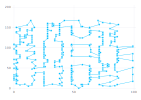

In [32]:
plot_solution(ludata', tour)

Final comments on part (1): 
* We can routinely solve some TSPs with millions of variables in seconds, but we can't solve some polynomial time problems with 100s of variables. 
* P vs NP isn't always a good measure of complexity.

# Wrapping-up part (1): The Concorde App
* The code laid out above doesn't scale to n=1000s, because of the way we laid out the problem data: e.g., we made Julia compute the full distance matrix, which is expensive.

* The heuristic we are using is also not quite state-of-the-art: it uses 2-opt swaps, but we get better solutions with 2-opt and 3-opt swaps.

* The Concorde TSP code combines these features, and manages its memory more carefully. Consequently, it can solve TSPs with millions of variables. Feel free to download it and try it out (see here: http://www.math.uwaterloo.ca/tsp/iphone/index.html)




* Callbacks (lazy, branching, informational).
* Parameter tuning
* Use TSP? Or bin packing?
* Visualize the difference between the approaches somehow (e.g. branch and bound trees, nodes of a graph with partial solutiuons).
* At end of section: some useful parameters to tune for CPLEX and Gurobi


# Appendix: Some useful solver parameters
Gurobi (and other high-quality solvers such as CPLEX) allow you to tweak a wide range of different parameters; sometimes tuning these can drastically improve performance. It can be kind of intimidating, though: Gurobi has over 100 parameters (and CPLEX has even more!), so which are the important ones?

Some useful ones:

Gurobi: 
* TimeLimit: how long the solver will run before giving up
* MIPGap: termination criterion for relative gap $\frac{UB-LB}{LB}$
* MIPFocus: High-level controls on solver priority (proving optimality or increasing bound or finding optimal solution)
* VarBranch: MIP branching strategy (pseudocost/strong branching)
* Cuts: How aggresive we want to be in our cut generation (higher values improve lower bound but might slow overall process).

CPLEX:
* CPX_PARAM_TILIM: how long the solver will run before giving up
* CPX_PARAM_EPOPT: termination criterion for relative gap $\frac{UB-LB}{LB}$
* CPX_PARAM_MIPEMPHASIS: High-level controls on solver priority (proving optimality or increasing bound or finding optimal solution)
* CPX_PARAM_VARSEL: MIP branching strategy (pseudocost/strong branching)
* CPX_PARAM_NODESEL: MIP node selection strategy

Is that it? Well, no, but you probably need domain knowledge about your problem to go much further. 